## Exploratory Data Analysis

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet('../data/curated/cleaned_retail_data.parquet')

In [ ]:
df

In [ ]:
df.shape

In [ ]:
df.info()

In [18]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,776844.000000,776844,776844.000000,776844.000000
mean,13.514945,2011-01-03 00:50:11.406228480,2.949687,15326.385108
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-07-02 14:37:00,1.250000,13979.000000
50%,6.000000,2010-12-02 13:49:00,1.950000,15252.000000
75%,12.000000,2011-08-01 13:31:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,146.071770,NaN,4.378932,1692.689970


In [19]:
print("Nombre de clients unique :", df['Customer ID'].nunique())
print("Nombre de produits unique :", df['StockCode'].nunique())
print("Nombre de factures unique :", df['Invoice'].nunique())
print("Nombre de pays unique :", df['Country'].nunique())

Nombre de clients unique : 5853
Nombre de produits unique : 4622
Nombre de factures unique : 36600
Nombre de pays unique : 41


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

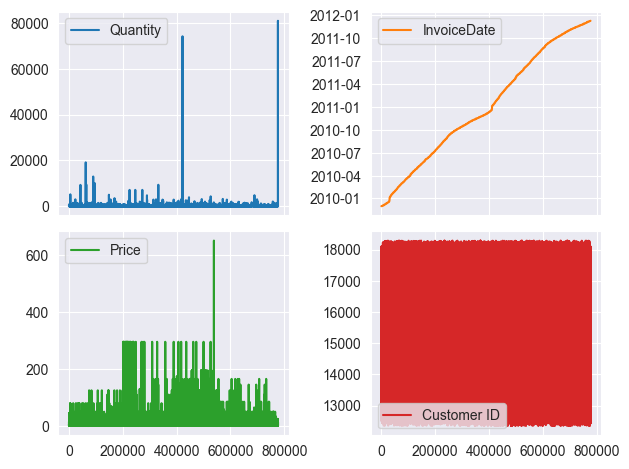

In [21]:
df.plot(subplots=True, layout=(2,2))

plt.tight_layout()
plt.show()

<Axes: xlabel='InvoiceDate'>

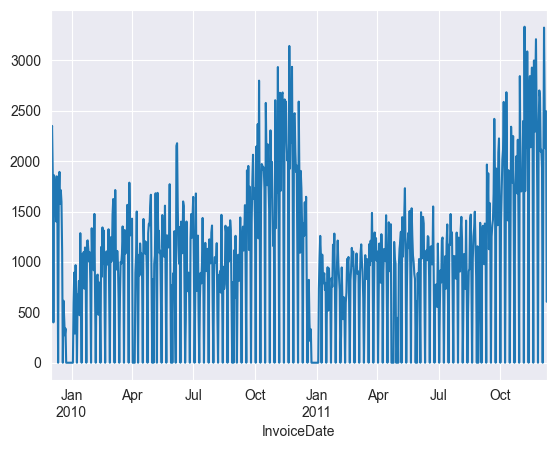

In [22]:
df['InvoiceDate'].value_counts().resample('D').sum().plot()

<Axes: xlabel='InvoiceDate'>

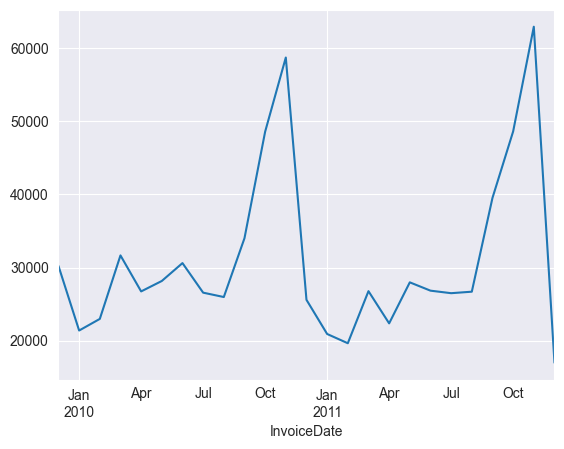

In [23]:
df['InvoiceDate'].value_counts().resample('ME').sum().plot()

We can see a seasonal trend in the sales data: traffic gradually increases until spring, drops in summer, then explodes dispproportionately from October to December. It maybe refers to christmas shopping season.
This seasonality guides our segmentation beacause it constitues a discriminative factor between regular customers and seasonal customers.

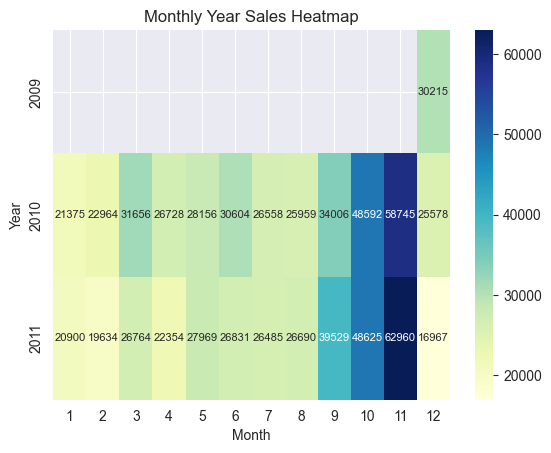

In [24]:
# Heatmap month X year
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
heatmap_data = df.groupby(['Year', 'Month'])['Invoice'].count().unstack()
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", annot_kws={"size": 8})
plt.title("Monthly Year Sales Heatmap")
plt.show()

We can see a clear difference between last quarter sales and the rest of the year.
We can get some ideas for our future clustering.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

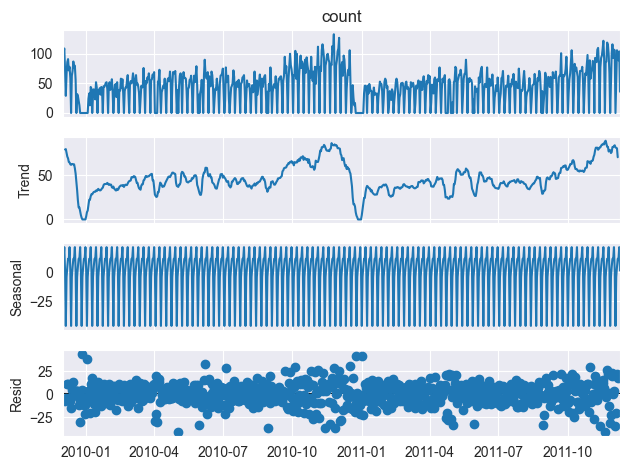

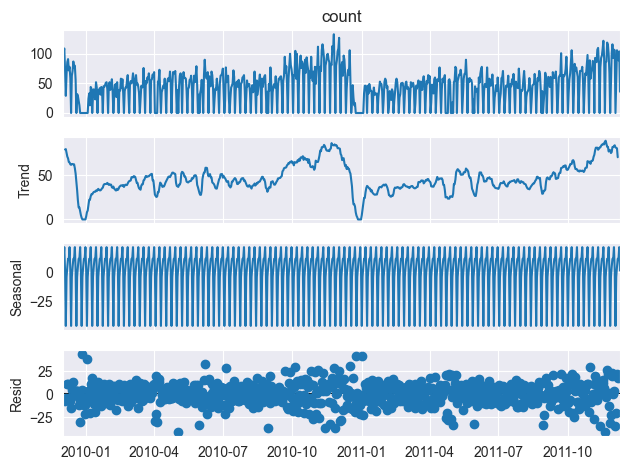

In [26]:
# Seasonal decomposition of daily sales
df_daily = df['InvoiceDate'].value_counts().resample("D").count()
seasonal_decompose(df_daily, model='additive').plot()

Trend: Overall increase in sales over time in the year.
Seasonality: Regular big peak between September and November.
Residual: A few anomalies, normal noise.
No stationarity detected.

# Feature Engineering

In [27]:
# Create temporal features
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Week'] = df['InvoiceDate'].dt.isocalendar().week
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

In [28]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,Day,DayOfWeek,Week
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,1,49
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,49
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,49
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,1,49
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,1,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776839,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,9,4,49
776840,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,9,4,49
776841,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,9,4,49
776842,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,9,4,49


## Cycling encoding of temporal features

<code-block lang="tex">
    \begin{equation}
    x_{sin} = \sin({2\pi*\frac{x}{n}})
    \end{equation}
    \begin{equation}
    x_{cos} = \cos({2\pi*\frac{x}{n}})
    \end{equation}
    where x = temporal feature value; n = number of existing values of the temporal feature
</code-block>

In [29]:
import numpy as np

In [30]:
def cyclic_encoding(data, column, max_val):
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / max_val)
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / max_val)
    return data

In [31]:
df = cyclic_encoding(df, 'Day', 31)
df = cyclic_encoding(df, 'DayOfWeek', 7)
df = cyclic_encoding(df, 'Week', 52)
df = cyclic_encoding(df, 'Month', 12)

In [32]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,...,DayOfWeek,Week,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Month_sin,Month_cos
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,...,1,49,0.201299,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,1,49,0.201299,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,1,49,0.201299,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,...,1,49,0.201299,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,...,1,49,0.201299,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776839,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,...,4,49,0.968077,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0
776840,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,...,4,49,0.968077,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0
776841,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,...,4,49,0.968077,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0
776842,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,...,4,49,0.968077,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0


In [33]:
df['HighSeason'] = df['Month'].isin([9,10,11]).astype(int)
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

In [34]:
df.loc[df['IsWeekend'] == 1]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,...,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Month_sin,Month_cos,HighSeason,IsWeekend
8638,490363,84950,assorted colour t-light holder,192,2009-12-05 10:11:00,0.72,13199.0,United Kingdom,2009,12,...,0.848644,0.528964,-0.974928,-0.222521,-0.354605,0.935016,-2.449294e-16,1.0,0,1
8639,490364,48185,door mat fairy cake,4,2009-12-05 10:25:00,6.75,13487.0,United Kingdom,2009,12,...,0.848644,0.528964,-0.974928,-0.222521,-0.354605,0.935016,-2.449294e-16,1.0,0,1
8640,490364,84836,zinc metal heart decoration,12,2009-12-05 10:25:00,1.25,13487.0,United Kingdom,2009,12,...,0.848644,0.528964,-0.974928,-0.222521,-0.354605,0.935016,-2.449294e-16,1.0,0,1
8641,490364,22415,white tissue ream,1,2009-12-05 10:25:00,7.95,13487.0,United Kingdom,2009,12,...,0.848644,0.528964,-0.974928,-0.222521,-0.354605,0.935016,-2.449294e-16,1.0,0,1
8642,490364,48187,door mat new england,4,2009-12-05 10:25:00,6.75,13487.0,United Kingdom,2009,12,...,0.848644,0.528964,-0.974928,-0.222521,-0.354605,0.935016,-2.449294e-16,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765796,580536,20682,red retrospot childrens umbrella,6,2011-12-04 16:07:00,3.25,12490.0,France,2011,12,...,0.724793,0.688967,-0.781831,0.623490,-0.464723,0.885456,-2.449294e-16,1.0,0,1
765797,580536,21156,retrospot childrens apron,8,2011-12-04 16:07:00,1.95,12490.0,France,2011,12,...,0.724793,0.688967,-0.781831,0.623490,-0.464723,0.885456,-2.449294e-16,1.0,0,1
765798,580536,21880,red retrospot tape,12,2011-12-04 16:07:00,0.65,12490.0,France,2011,12,...,0.724793,0.688967,-0.781831,0.623490,-0.464723,0.885456,-2.449294e-16,1.0,0,1
765799,580536,22090,paper bunting retrospot,6,2011-12-04 16:07:00,2.95,12490.0,France,2011,12,...,0.724793,0.688967,-0.781831,0.623490,-0.464723,0.885456,-2.449294e-16,1.0,0,1


In [35]:
invoice_gaps = (
    df.groupby(['Customer ID', 'Invoice'])['InvoiceDate']
      .min()                               # 1 date par facture
      .reset_index()
      .sort_values(['Customer ID', 'InvoiceDate'])
)

invoice_gaps['DaysSincePrevInvoice'] = (
    invoice_gaps.groupby('Customer ID')['InvoiceDate']
                .diff()
                .dt.days
)

In [36]:
df = df.merge(
    invoice_gaps[['Customer ID', 'Invoice', 'DaysSincePrevInvoice']],
    on=['Customer ID', 'Invoice'],
    how='left'
)

In [37]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,...,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Month_sin,Month_cos,HighSeason,IsWeekend,DaysSincePrevInvoice
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,...,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0,0,0,NaN
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0,0,0,NaN
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0,0,0,NaN
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,...,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0,0,0,NaN
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,...,0.979530,0.781831,0.623490,-0.354605,0.935016,-2.449294e-16,1.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776839,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,...,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0,0,0,72.0
776840,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,...,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0,0,0,72.0
776841,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,...,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0,0,0,72.0
776842,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,...,-0.250653,-0.433884,-0.900969,-0.354605,0.935016,-2.449294e-16,1.0,0,0,72.0


## RFM agregation

In [38]:
snapshot_date = df['InvoiceDate'].max()
rfm_df = df.groupby('Customer ID').agg(
    Recency = ('InvoiceDate',lambda x: (snapshot_date - x.max()).days),
    Frequency=('Invoice', 'nunique'),  # total number of invoices/checkout transactions
    Monetary=('Price', lambda x: (x * df.loc[x.index, 'Quantity']).sum()),  # total spent amount
    CustomerLifespan =('InvoiceDate', lambda x: (x.max() - x.min()).days),  # number of days between 1st and last purchase
    AvgGap=('DaysSincePrevInvoice', 'mean'),  # mean gap between invoices
    MedianGap=('DaysSincePrevInvoice', 'median'),
    MaxGap=('DaysSincePrevInvoice', 'max')
).reset_index()

In [39]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,CustomerLifespan,AvgGap,MedianGap,MaxGap
0,12346.0,325,3,77352.96,321,122.250000,118.0,203.0
1,12347.0,1,8,4921.53,402,61.456044,53.0,90.0
2,12348.0,74,5,1658.40,362,77.814815,80.0,173.0
3,12349.0,18,3,3678.69,570,299.857143,389.0,389.0
4,12350.0,309,1,294.40,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5848,18283.0,3,22,2658.95,654,33.327009,20.0,143.0
5849,18284.0,431,1,461.68,0,NaN,NaN,NaN
5850,18285.0,660,1,427.00,0,NaN,NaN,NaN
5851,18286.0,476,2,1296.43,247,247.000000,247.0,247.0


### Seasonal features

In [48]:
# Favorite month of purchase
month_count = df.groupby(['Customer ID', 'Month'])['Invoice'].count().reset_index()
favorite_month = month_count.loc[month_count.groupby('Customer ID')['Invoice'].idxmax()]
favorite_month = favorite_month[['Customer ID', 'Month']].rename(columns={'Month': 'FavMonth'})

rfm_df = rfm_df.merge(favorite_month, on='Customer ID', how='left')

In [49]:
# Purchase percentage in high season (Sep, Oct, Nov)
highseason_count = df.groupby('Customer ID')['HighSeason'].mean().reset_index().rename(columns={'HighSeason': 'PctHighSeason'})
rfm_df = rfm_df.merge(highseason_count, on='Customer ID', how='left')

In [50]:
# Purchase percentage on weekends
weekend_ratio = df.groupby('Customer ID')['IsWeekend'].mean().reset_index().rename(columns={'IsWeekend': 'PctWeekend'})
rfm_df = rfm_df.merge(weekend_ratio, on='Customer ID', how='left')

In [51]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,CustomerLifespan,AvgGap,MedianGap,MaxGap,FavMonth,PctHighSeason,PctWeekend
0,12346.0,325,3,77352.96,321,122.250000,118.0,203.0,6,0.000000,0.000000
1,12347.0,1,8,4921.53,402,61.456044,53.0,90.0,10,0.391892,0.180180
2,12348.0,74,5,1658.40,362,77.814815,80.0,173.0,9,0.456522,0.043478
3,12349.0,18,3,3678.69,570,299.857143,389.0,389.0,11,0.732558,0.000000
4,12350.0,309,1,294.40,0,NaN,NaN,NaN,2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5848,18283.0,3,22,2658.95,654,33.327009,20.0,143.0,11,0.376068,0.105769
5849,18284.0,431,1,461.68,0,NaN,NaN,NaN,10,1.000000,0.000000
5850,18285.0,660,1,427.00,0,NaN,NaN,NaN,2,0.000000,0.000000
5851,18286.0,476,2,1296.43,247,247.000000,247.0,247.0,8,0.000000,0.000000
